## CE-like background in offspill 

SAM definition: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root` 

First file: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00050440.root`

File lists: `/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.*.txt`

## Imports

Switched to using installed pyutils package

In [1]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import hist
import gc
import sys

# sys.path.append("../../../EventNtuple/utils/pyutils")
from pyutils.pyprocess import Processor, Skeleton
from pyutils.pyplot import Plot
from pyutils.pyprint import Print
from pyutils.pyselect import Select
from pyutils.pyvector import Vector

sys.path.append("../common")
from cut_manager import CutManager
from analyse import Analyse

# Create Processor 

In [2]:
# Create your custom processor class
# We inherit from Skeleton - this gives us many pre-built methods without writing extra code
class CosmicProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    def __init__(self):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class's __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        # Now override parameters from the Skeleton with the ones we need
        # Data selection configuration 
        self.defname = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root"
        # self.file_list_path = "//exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_24.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_99.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-test/TestFileLists/local_file_list.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-test/TestFileLists/local_0.txt"
    
        self.branches = { 
            "evt" : [
                "run",
                "subrun",
                "event",
            ],
            "crv" : [
                "crvcoincs.time",
                "crvcoincs.nHits"
            ],
            "trk" : [
                "trk.nactive", 
                "trk.pdg", 
                "trkqual.valid",
                "trkqual.result"
            ],
            "trkfit" : [
                "trksegs",
                "trksegpars_lh"
            ],
            "trkmc" : [
                "trkmcsim"
            ]
        }
        self.use_remote = True     # Use remote file via mdh
        self.location = "disk"     # File location
        self.max_workers = 50      # Limit the number of workers
        self.verbosity = 2         # Set verbosity 
        self.use_processes = True  # Use processes rather than threads
        
        # Now add your own analysis-specific parameters 

        # Init analysis methods
        # Would be good to load an analysis config here 
        self.analyse = Analyse(verbosity=0)
            
        # Custom prefix for log messages from this processor
        self.print_prefix = "[CosmicProcessor] "
        print(f"{self.print_prefix}Initialised")
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class's process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name): 
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local pyprocess Processor to extract data from this file
            # This uses the configuration parameters from our class
            this_processor = Processor(
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0 # self.verbosity        # Reduce output in worker threads
            )
            
            # Extract the data 
            this_data = this_processor.process_data(
                file_name = file_name, 
                branches = self.branches
            )
            
            # ---- Analysis ----            
            results = self.analyse.execute(this_data, file_name)

            # Clean up
            gc.collect()

            return results 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"{self.print_prefix}Error processing {file_name}: {e}")
            return None

    ## Need postprocessing and failure handling!    

In [3]:
# ==========================================
# Create and run the processor
# ==========================================
# Create an instance of our custom processor
cosmic_processor = CosmicProcessor()

# Run the processor on all files
# The execute method comes from the Skeleton parent class
# This starts a parent Processor and submits the process function to the threads

# import tracemalloc
# import os
# import psutil

# # Start memory tracking
# tracemalloc.start()

# # Take a baseline snapshot
# print("Starting memory tracking")
# baseline = tracemalloc.take_snapshot()

# # Print initial memory usage
# process = psutil.Process(os.getpid())
# memory_before = process.memory_info().rss / (1024 * 1024)
# print(f"Initial memory usage: {memory_before:.2f} MB")

# Execute your processor
results = cosmic_processor.execute()

# # Take final snapshot and measure memory increase
# snapshot = tracemalloc.take_snapshot()
# memory_after = process.memory_info().rss / (1024 * 1024)
# memory_diff = memory_after - memory_before

# # Compare snapshots and show top differences
# print(f"\nTOP 10 MEMORY DIFFERENCES:")
# top_stats = snapshot.compare_to(baseline, 'lineno')
# for stat in top_stats[:10]:
#     print(stat)

# # Print overall memory change
# print(f"\nTotal memory change: {memory_diff:.2f} MB ({memory_before:.2f} MB → {memory_after:.2f} MB)")

[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyutils] ⭐️ Setting up...
[pyutils] ✅ Ready
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] 👀 Loading file list for SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
[pyprocess] ✅ Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
	Count: 817 files
[pyprocess] ⭐️ Starting processing on 817 files with 50 processes


Processing: 100%|██████████████████████████████| 817/817 [04:32<00:00,  3.00file/s, successful=817, failed=0]

[pyprocess] ⭐️ Returning 817 results
[Skeleton] ✅ Analysis complete


In [4]:
# for i, result in enumerate(results):

#     if len(result["filtered_data"]["trkfit"]) > 0:
#         print(i) # , result)
#         # print(result["filtered_data"]["evt"]["subrun"], result["filtered_data"]["evt"]["event"])
#         print(results["file_id"])

In [4]:
# Helper to convert the cut stats into a list 
def get_stats_list(results):
    # One line solution
    #  return [result["cut_stats"] for result in results if "cut_stats" in result]
    # Readable solution 
    stats = [] 
    for result in results: 
        if "cut_stats" in result: 
            stats.append(result["cut_stats"])
    return stats

stats = get_stats_list(results)

cut_manager = CutManager()

combined_stats = cut_manager.combine_cut_stats(stats)
cut_manager.print_cut_stats(stats=combined_stats, active_only=False, csv_name="../../txt/cut_stats_offspill.csv")

[CutManager] ⭐️ Cut statistics
--------------------------------------------------------------------------------------------------------------
Cut                  Events passing       Absolute frac. [%]   Relative frac. [%]   Description                   
--------------------------------------------------------------------------------------------------------------
No cuts              5754129              100.00               100.00               No selection applied          
is_truth_electron    2319356              40.31                40.31                Track parents are electrons (truth PID)
is_reco_electron     2136407              37.13                92.11                Tracks are assumed to be electrons (trk)
is_downstream        1524458              26.49                71.36                Downstream tracks only (p_z > 0 through tracker)
has_hits             1293380              22.48                84.84                Minimum of 20 active hits in the tracker
good_trkqu

In [5]:
print(results[0]["histograms"])
# !cat ../txt/cut_stats_ana_2.csv

{'Wide range': Hist(
  Regular(30, 0, 300, name='momentum', label='Momentum [MeV/c]'),
  StrCategory(['All tracks', 'CE-like tracks', 'Unvetoed CE-like tracks'], name='selection', label='Selection'),
  storage=Double()) # Sum: 38989.0 (39239.0 with flow), 'Signal region': Hist(
  Regular(13, 103.6, 104.9, name='momentum', label='Momentum [MeV/c]'),
  StrCategory(['All tracks', 'CE-like tracks', 'Unvetoed CE-like tracks'], name='selection', label='Selection'),
  storage=Double()) # Sum: 342.0}


In [7]:
# Should be in postprocessing 

def combine_histograms(results):
    """Combine histograms from multiple files
    
    Args:
        file_results: Dictionary with file IDs as keys and results as values
                     Each result contains a 'histograms' dict
    
    Returns:
        dict: Combined histograms
    """
    combined_hists = {}
    
    # Check if we have results
    if not results:
        return None
    
    # Loop through all files
    for result in results: # 
        # Skip if no histograms in this file
        if 'histograms' not in result or not result['histograms']:
            continue
        
        # Process each histogram type
        for hist_name, hist_obj in result['histograms'].items():
            if hist_name not in combined_hists:
                # First time seeing this histogram type, initialise
                combined_hists[hist_name] = hist_obj.copy()
            else:
                # Add this histogram to the accumulated one
                combined_hists[hist_name] += hist_obj

    return combined_hists

# Combine hists 
combined_histograms = combine_histograms(results)

/home/sgrant/.conda/envs/mu2e_env.v1.3.0/lib/python3.12/site-packages/hist/basehist.py:444: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/home/sgrant/.conda/envs/mu2e_env.v1.3.0/lib/python3.12/site-packages/hist/basehist.py:444: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


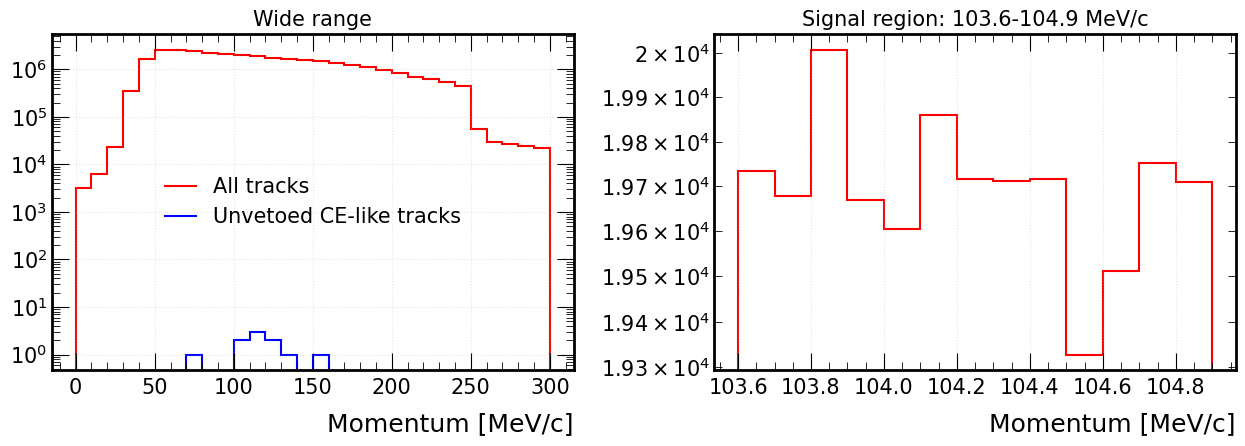

In [8]:

# Now you can plot them
plt.style.use("../../../EventNtuple/utils/pyutils/mu2e.mplstyle")
fig, axes = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

# Plot wide range in first subplot
if 'Wide range' in combined_histograms:
    h_wide = combined_histograms['Wide range']
    # Can also include "CE-like tracks"
    h_wide = h_wide[{"selection": ["All tracks", "Unvetoed CE-like tracks"]}] # slice(-2, None)}]  # Last 2 selections
    h_wide.plot1d(overlay='selection', ax=axes[0])
    # h_wide.sum().value
    axes[0].set_title("Wide range")
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(frameon=False, loc="best")

# Plot signal region in second subplot
if 'Signal region' in combined_histograms:
    h_signal = combined_histograms['Signal region']
    
    h_signal = h_signal[{"selection": ["All tracks", "Unvetoed CE-like tracks"]}] 
    h_signal.plot1d(overlay='selection', ax=axes[1])
    axes[1].set_title("Signal region: 103.6-104.9 MeV/c")
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylabel("")  # Remove duplicate y-label
    # axes[1].legend(frameon=False, loc="best")


plt.tight_layout()
plt.savefig("../../img/h1_ana_mom_offspill.png", dpi=300)
plt.show()

In [9]:
h_wide = combined_histograms['Wide range']
h_wide = h_wide[{'selection': 'Unvetoed CE-like tracks'}]  # Use dictionary-based slicing
n = h_wide.sum()
n

10.0

In [10]:
# !../../txtoffspill/

In [10]:
# len(results)

# # Format the results loop more nicely
# for i, result in enumerate(results):
#     if len(result["filtered_data"]["trkfit"]) > 0:
#         print(f"Entry #{i}:")
#         print(f"  Subrun: {result['filtered_data']['evt']['subrun'][0]}")
#         print(f"  Event:  {result['filtered_data']['evt']['event'][0]}")
#         print(f"  File:   {result['file_id']}")
#         print("-" * 40)  # separator line

# # Write results to a text file
# fout_name = "../../txt/offspill/background_events.txt"
# with open(fout_name, "w") as f:

#     for i, result in enumerate(results):
#         if len(result["filtered_data"]["trkfit"]) > 0:
#             f.write(f"Entry #{i}:\n")
#             f.write(f"  Subrun: {result['filtered_data']['evt']['subrun'][0]}\n")
#             f.write(f"  Event:  {result['filtered_data']['evt']['event'][0]}\n")
#             f.write(f"  File:   {result['file_id']}\n")
#             f.write("-" * 40 + "\n")  # separator line

# print(f"\tWrote {fout_name}")


# Build output string once
output = []
for i, result in enumerate(results):
    if len(result["filtered_data"]["trkfit"]) > 0:
        output.append(f"Entry #{i}:")
        output.append(f"  Subrun: {result['filtered_data']['evt']['subrun'][0]}")
        output.append(f"  Event:  {result['filtered_data']['evt']['event'][0]}")
        output.append(f"  File:   {result['file_id']}")
        output.append("-" * 40)

output = "\n".join(output)

# Print to console
print(output)

# Write to file
fout_name = "../../txt/offspill/background_events.txt"
with open(fout_name, "w") as f:
    f.write(output)

print(f"\tWrote {fout_name}")

Entry #23:
  Subrun: 4457
  Event:  157431
  File:   nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00000075.root
----------------------------------------
Entry #46:
  Subrun: 1445
  Event:  465577
  File:   nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00000045.root
----------------------------------------
Entry #103:
  Subrun: 14080
  Event:  216096
  File:   nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00005119.root
----------------------------------------
Entry #217:
  Subrun: 19742
  Event:  359830
  File:   nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00015581.root
----------------------------------------
Entry #416:
  Subrun: 40152
  Event:  439475
  File:   nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00035082.root
----------------------------------------
Entry #491:
  Subrun: 48098
 

In [18]:
def combine_arrays(results):
    """Combine filtered arrays from multiple files
    """
    arrays_to_combine = []
    # Check if we have results
    if not results:
        return None
    # Loop through all files
    for result in results: #
        array = ak.Array(result["filtered_data"])
        if len(array) == 0:
            continue

        # print(array["evt"]["subrun"], array["evt"]["event"])
        # 
        # Concatenate arrays
        arrays_to_combine.append(array)
    return ak.concatenate(arrays_to_combine)
    
data = combine_arrays(results)
# printer = Print()
# printer.print_n_events(data, n_events=len(data))

In [19]:
# for event in data: 
#     float data["trkfit"]["trksegs"]["time"])

for i in range(len(data)):

    trk_time = data["trkfit"]["trksegs"]["time"][i]
    crv_times = data["crv"]["crvcoincs.time"][i]

    dt = []
    for crv_time in crv_times: 
        dt.append(trk_time[0][0] - crv_time)
        
    print(trk_time, crv_times, dt)

    # for crv_time in crv_times:
    #     trk_time
        
    # print(data["trkfit"]["trksegs"]["time"][i], data["crv"]["crvcoincs.time"][i])

[[6.56e+04]] [] []
[[5.91e+04]] [] []
[[2.37e+04]] [] []
[[8.13e+04]] [] []
[[3.13e+04]] [] []
[[9.91e+04]] [] []
[[7.24e+04]] [] []
[[8.85e+04]] [8.83e+04] [151.1032993425033]
[[5.93e+04]] [] []
[[1.18e+03]] [] []
